# Regularization methods

The main idea behind the regularization (shrinkage) methods is to impose a constraint to the weights of the model.
Where depending on the parameter $\lambda$ we contro how much of penalty we will impose on the large coefficients from the model.

It turns out that shrinking the coefficients of the model significantly lowers the variance of the fit.

Two best-known methods for shrinking the regression coefficients are $\textit{lasso}$ and $\textit{ridge regression}$.

### Ridge regression

Ridge regression imposes a L2 norm of the coefficients in the function to minimize beside the usual loss term and the function that is minimized is as follows:

$$
\sum_{i=1}^{n} \biggl( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}\biggr)^2 - \lambda \sum_{j=1}^{p}\beta_j^2
$$

Here the $\lambda$ is a tuning parameter that controls how big impact will the regularization term have on the final coefficients. Notice that if $\lambda$ is 0 we get the normal RSS from the linear regression and if $\lambda \rightarrow \infty$ the regression coefficients tend to 0.
Selecting the right choice for the tuning parameter is a crucial step of training a ridge regression and is often done using the cross-validation method.

We can plot the geometric representation of lasso and rigde regression, where the highlighted regions are the conditions on the parameters, the point of contact between the regular mean square model with the constraint area is the optimal ridge and lasso parametes.

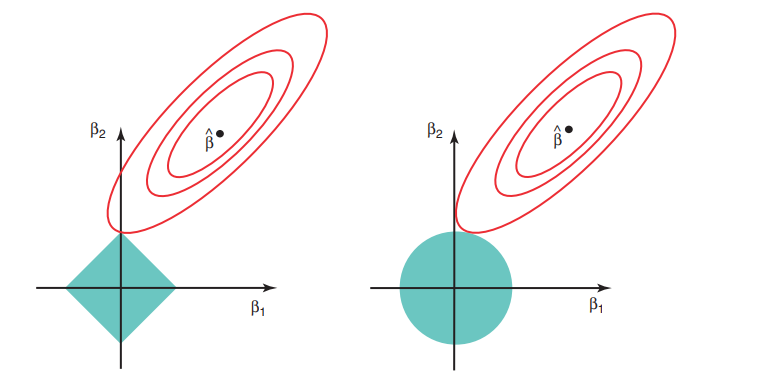


In [37]:
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
features = boston.feature_names
X_train, X_test, y_train, y_test = train_test_split(df, boston.target, train_size=0.9)

In [34]:
class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        X = np.column_stack((np.ones(len(X)), X))
        
        X_transpose_X = np.dot(X.T, X)
        regularized_term = self.alpha + np.identity(X.shape[1])
        inversed = np.linalg.inv(X_transpose_X + regularized_term)
        self.coefficients = np.dot(np.dot(inversed,X.T), y)
        
    def predict (self, X):
        X = np.column_stack((np.ones(len(X)), X))
        
        y_pred = np.dot(X, self.coefficients)
        return y_pred
    


In [193]:
alpha = np.linspace(0, 2, 100)

def find_opt_alpha(alpha, X_train, X_test, y_train, y_test):
    mse = []
    coefficients = []
    for alpha in alpha:
        ridge = RidgeRegression(alpha=alpha)
        ridge.fit(X_train, y_train)
        mse.append(mean_squared_error(ridge.predict(X_test), y_test))
        coefficients.append(ridge.coefficients)
        
    return mse, coefficients

In [194]:
mse_values, coefficients_values = find_opt_alpha(alpha, X_train, X_test, y_train, y_test)

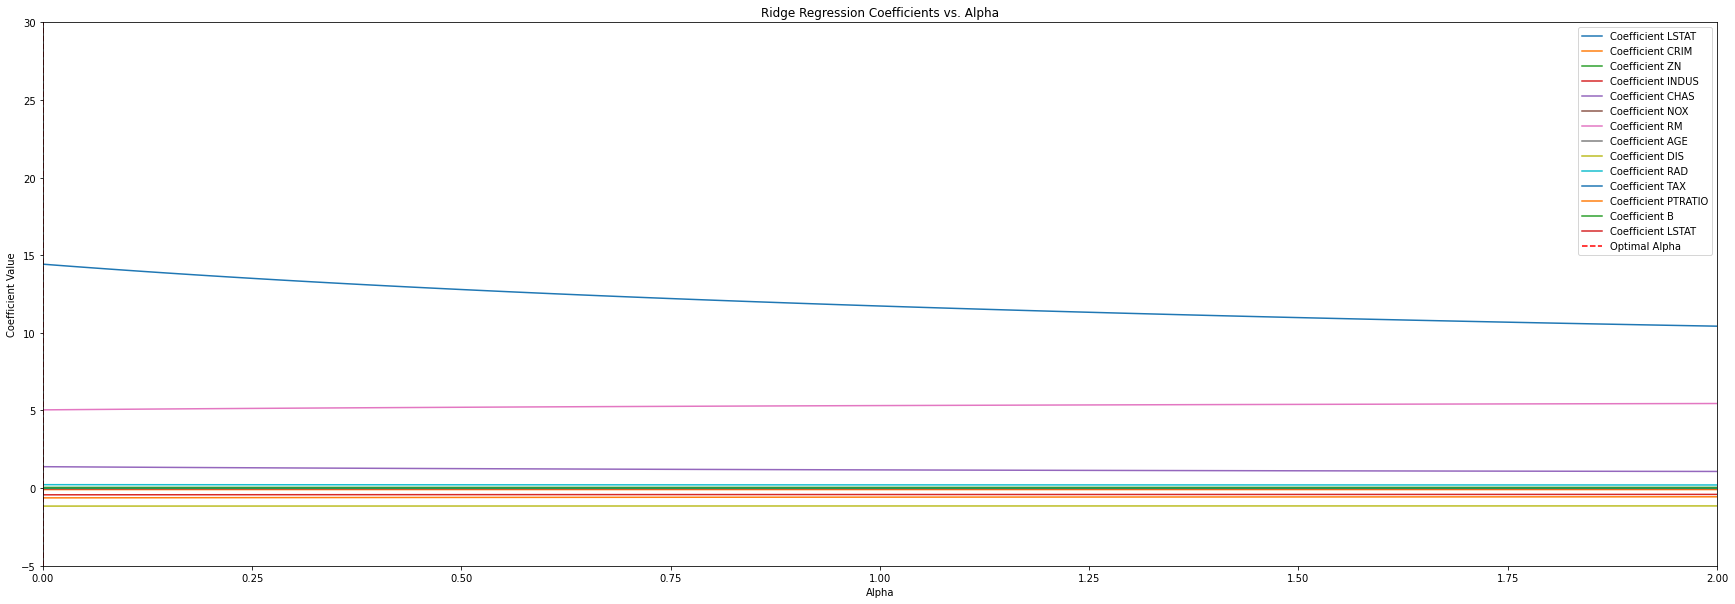

In [196]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# Set up the plot
fig, ax = plt.subplots(figsize=(30,10))
lines = [ax.plot([], [], label=f'Coefficient {boston.feature_names[i-1]}')[0] for i in range(len(coefficients_values[0]))]
ax.axvline(x=alpha[np.argmin(mse_values)], color='r', linestyle='--', label='Optimal Alpha')
ax.set_xlabel('Alpha')
ax.set_xlim(0, 2)
ax.set_ylim(-5, 30)
ax.set_ylabel('Coefficient Value')
ax.set_title('Ridge Regression Coefficients vs. Alpha')
ax.legend()


for line in lines:
    line.set_data([], [])
    
# Update function for animation
def update(frame):
    coefficients_array = np.array(coefficients_values)  # Convert to NumPy array
    for i, line in enumerate(lines):
        line.set_data(alpha[:frame+1], coefficients_array[:frame+1, i])
    return lines

# Create the animation
animation = FuncAnimation(fig, update, frames=len(alpha), interval=100, blit=True)
HTML(animation.to_jshtml())
plt.show()


In [197]:
print(f'Optimal alpha for ridge regression is: {alpha[mse.index(min(mse))]}') 
print(f'Coefficients for the optimal alpha are: \n {coefficients_values[mse.index(min(mse))]}')

Optimal alpha for ridge regression is: 0.8686868686868687
Coefficients for the optimal alpha are: 
 [ 1.19675047e+01 -9.20471845e-02  4.78253824e-02 -2.86459802e-02
  1.19290630e+00 -7.93217721e+00  5.29123761e+00 -6.56125054e-03
 -1.14890425e+00  2.11703413e-01 -1.06353399e-02 -5.84195878e-01
  1.35561930e-02 -4.13039137e-01]


### Lasso Regression

Another type of parameter regularization method is Lasso. In the lasso regression we impose the L1 constraint on the coefficients. Similarly to the ridge we add the penal term to the mse and use it for the optimization:

$$
\sum_{i=1}^{n} \biggl( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}\biggr)^2 - \lambda \sum_{j=1}^{p}\lvert \beta_j \rvert
$$
It is important to note that lasso can force some coefficients to be zero and doing this in a way performs a feature selection.

In [201]:
from sklearn.linear_model import Lasso
for alp in alpha:
    lasso = Lasso(alpha=alp)
    lasso.fit(X_train, y_train)
    mse.append(mean_squared_error(lasso.predict(X_test), y_test))
print(f'Optimal alpha for Lasso regression is: {alpha[mse.index(min(mse))]}')

Optimal alpha for Lasso regression is: 0.8686868686868687


Last extension of the idea of regularization of the coefficients is the Elastic Net.
The idea behind the elastic net is to use both Lasso and Ridge regression as a convex combination and hopefully incorporate the best parts of each. 
The formulation of Elastic net condition is to minimize the loss function with the subject to:

$$
(1 - \alpha) \lVert \beta \rVert_1 + \alpha \lVert \beta \rVert^2 \leq t
$$
for some t